In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import matplotlib.mlab as mlab
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import warnings
warnings.filterwarnings("ignore")

In [206]:
cleaned = pd.read_feather('cleaned_yellow_18.feather').drop('index', axis=1)
cleaned

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,date,hour
0,1,2018-05-01 00:20:02,2018-05-01 00:56:06,1,18.10,2,N,142,132,1,52.0,0.0,0.5,14.60,5.76,0.3,73.16,05-01,00 00
1,1,2018-05-01 00:51:09,2018-05-01 01:07:11,1,8.60,1,N,162,95,1,25.5,0.5,0.5,6.50,5.76,0.3,39.06,05-01,00 00
2,2,2018-05-01 00:42:23,2018-05-01 01:05:28,1,17.77,2,N,132,162,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,05-01,00 00
3,2,2018-05-01 00:10:29,2018-05-01 00:35:31,1,11.90,1,N,162,220,1,34.5,0.5,0.5,15.38,2.64,0.3,53.82,05-01,00 00
4,1,2018-05-01 00:31:26,2018-05-01 01:01:43,1,19.50,2,N,132,141,1,52.0,0.0,0.5,10.00,5.76,0.3,68.56,05-01,00 00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252205,2,2018-03-31 23:11:27,2018-03-31 23:47:52,1,12.08,1,N,158,17,1,37.5,0.5,0.5,8.00,5.76,0.3,52.56,03-31,23 00
2252206,2,2018-03-31 23:27:13,2018-03-31 23:42:12,1,3.53,1,N,145,48,1,13.5,0.5,0.5,2.00,5.76,0.3,22.56,03-31,23 00
2252207,2,2018-03-31 23:24:44,2018-03-31 23:42:20,1,8.96,1,N,138,236,1,26.0,0.5,0.5,6.61,5.76,0.3,39.67,03-31,23 00
2252208,1,2018-03-31 23:40:26,2018-04-01 00:17:19,1,19.30,2,N,132,24,1,52.0,0.0,0.5,10.00,5.76,0.3,68.56,03-31,23 00


In [ ]:
# split the datatime into seperate date and time
cleaned['date'] = cleaned['tpep_pickup_datetime'].str[5:10]
cleaned['hour'] = cleaned['tpep_pickup_datetime'].str[10:13]+" 00"
cleaned.reset_index().to_feather('cleaned_yellow_18.feather')

### Add additional data -- weather

In [64]:
# function to convert temp from F to C
def ConvertFtoC(F):
    C = (5 / 9) * (F - 32)
    return C

In [65]:
# read in the weather data
weather = pd.read_csv("../raw_data/weather_2018.csv")

In [163]:
weather.shape


(181, 44)

In [66]:
data = weather[["DATE", "AWND", "PRCP", "SNOW", "SNWD", "TAVG", "TMAX", "TMIN", "WT01", "WT02", "WT03", "WT06", "WT08"]]
data

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WT01,WT02,WT03,WT06,WT08
0,2018-01-01,7.83,0.00,0.0,0.0,NaN,19,7,NaN,NaN,NaN,NaN,NaN
1,2018-01-02,8.05,0.00,0.0,0.0,NaN,26,13,NaN,NaN,NaN,NaN,NaN
2,2018-01-03,3.13,0.00,0.0,0.0,NaN,30,16,NaN,NaN,NaN,NaN,NaN
3,2018-01-04,12.53,0.76,9.8,1.2,NaN,29,19,1.0,1.0,NaN,NaN,1.0
4,2018-01-05,12.97,0.00,0.0,7.1,NaN,19,9,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,2018-06-26,3.80,0.00,0.0,0.0,NaN,78,61,NaN,NaN,NaN,NaN,NaN
177,2018-06-27,3.58,0.01,0.0,0.0,NaN,73,66,1.0,NaN,NaN,NaN,NaN
178,2018-06-28,2.91,1.36,0.0,0.0,NaN,83,70,1.0,1.0,1.0,NaN,NaN
179,2018-06-29,2.68,0.00,0.0,0.0,NaN,89,70,NaN,NaN,NaN,NaN,NaN


In [67]:
# calculate the ave temp and identify whether a day has bad weather
data['TAVG'] = (ConvertFtoC(data['TMAX']) + ConvertFtoC(data['TMIN'])) / 2
data['bad weather'] = data[["WT01", "WT02", "WT03", "WT06", "WT08"]].sum(axis=1)
data = data.drop(["TMAX", "TMIN", "WT01", "WT02", "WT03", "WT06", "WT08"], axis='columns')
data['bad weather'] = np.where(data['bad weather']>0, 'Y', 'N')
data

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,bad weather
0,2018-01-01,7.83,0.00,0.0,0.0,-10.555556,N
1,2018-01-02,8.05,0.00,0.0,0.0,-6.944444,N
2,2018-01-03,3.13,0.00,0.0,0.0,-5.000000,N
3,2018-01-04,12.53,0.76,9.8,1.2,-4.444444,Y
4,2018-01-05,12.97,0.00,0.0,7.1,-10.000000,N
...,...,...,...,...,...,...,...
176,2018-06-26,3.80,0.00,0.0,0.0,20.833333,N
177,2018-06-27,3.58,0.01,0.0,0.0,20.833333,Y
178,2018-06-28,2.91,1.36,0.0,0.0,24.722222,Y
179,2018-06-29,2.68,0.00,0.0,0.0,26.388889,N


In [68]:
cleaned = cleaned.drop(["payment_type"], axis='columns')

In [69]:
data['DATE'] = data['DATE'].str[5:10]
data

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,bad weather
0,01-01,7.83,0.00,0.0,0.0,-10.555556,N
1,01-02,8.05,0.00,0.0,0.0,-6.944444,N
2,01-03,3.13,0.00,0.0,0.0,-5.000000,N
3,01-04,12.53,0.76,9.8,1.2,-4.444444,Y
4,01-05,12.97,0.00,0.0,7.1,-10.000000,N
...,...,...,...,...,...,...,...
176,06-26,3.80,0.00,0.0,0.0,20.833333,N
177,06-27,3.58,0.01,0.0,0.0,20.833333,Y
178,06-28,2.91,1.36,0.0,0.0,24.722222,Y
179,06-29,2.68,0.00,0.0,0.0,26.388889,N


In [211]:
# merge the weather data into the taxi records
cleaned_data = pd.merge(cleaned, data, left_on='date', right_on='DATE')
cleaned_data.reset_index().to_feather('cleaned_data.feather')
cleaned_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,date,hour,DATE,AWND,PRCP,SNOW,SNWD,TAVG,bad weather
0,1,2018-05-01 00:20:02,2018-05-01 00:56:06,1,18.10,2,N,142,132,1,...,73.16,05-01,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N
1,1,2018-05-01 00:51:09,2018-05-01 01:07:11,1,8.60,1,N,162,95,1,...,39.06,05-01,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N
2,2,2018-05-01 00:42:23,2018-05-01 01:05:28,1,17.77,2,N,132,162,1,...,70.27,05-01,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N
3,2,2018-05-01 00:10:29,2018-05-01 00:35:31,1,11.90,1,N,162,220,1,...,53.82,05-01,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N
4,1,2018-05-01 00:31:26,2018-05-01 01:01:43,1,19.50,2,N,132,141,1,...,68.56,05-01,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252205,2,2018-03-30 23:59:04,2018-03-31 00:13:10,1,7.61,1,N,138,262,1,...,36.32,03-30,23 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y
2252206,2,2018-03-30 10:50:39,2018-03-31 10:18:10,1,17.98,2,N,132,164,1,...,70.27,03-30,10 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y
2252207,2,2018-03-30 23:58:36,2018-03-31 00:11:49,1,5.57,1,N,170,260,1,...,28.56,03-30,23 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y
2252208,2,2018-03-30 22:33:01,2018-03-30 22:47:19,2,3.20,1,N,68,145,1,...,21.06,03-30,22 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y


In [212]:
# get new feature of time duration of a trip
cleaned_data['tpep_pickup_datetime'] = pd.to_datetime(cleaned_data['tpep_pickup_datetime'])
cleaned_data['tpep_dropoff_datetime'] = pd.to_datetime(cleaned_data['tpep_dropoff_datetime'])
cleaned_data['date'] = cleaned_data['tpep_pickup_datetime'].dt.normalize()
cleaned_data['time'] = cleaned_data['tpep_dropoff_datetime'] - cleaned_data['tpep_pickup_datetime']
cleaned_data['time'] = cleaned_data['time']/np.timedelta64(1,'m')
cleaned_data['T_hour'] = cleaned_data['tpep_pickup_datetime'].dt.hour
cleaned_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,hour,DATE,AWND,PRCP,SNOW,SNWD,TAVG,bad weather,time,T_hour
0,1,2018-05-01 00:20:02,2018-05-01 00:56:06,1,18.10,2,N,142,132,1,...,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N,36.066667,0
1,1,2018-05-01 00:51:09,2018-05-01 01:07:11,1,8.60,1,N,162,95,1,...,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N,16.033333,0
2,2,2018-05-01 00:42:23,2018-05-01 01:05:28,1,17.77,2,N,132,162,1,...,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N,23.083333,0
3,2,2018-05-01 00:10:29,2018-05-01 00:35:31,1,11.90,1,N,162,220,1,...,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N,25.033333,0
4,1,2018-05-01 00:31:26,2018-05-01 01:01:43,1,19.50,2,N,132,141,1,...,00 00,05-01,4.25,0.00,0.0,0.0,17.777778,N,30.283333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252205,2,2018-03-30 23:59:04,2018-03-31 00:13:10,1,7.61,1,N,138,262,1,...,23 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y,14.100000,23
2252206,2,2018-03-30 10:50:39,2018-03-31 10:18:10,1,17.98,2,N,132,164,1,...,10 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y,1407.516667,10
2252207,2,2018-03-30 23:58:36,2018-03-31 00:11:49,1,5.57,1,N,170,260,1,...,23 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y,13.216667,23
2252208,2,2018-03-30 22:33:01,2018-03-30 22:47:19,2,3.20,1,N,68,145,1,...,22 00,03-30,4.03,0.03,0.0,0.0,11.666667,Y,14.300000,22


In [213]:
# classify the type of day
cal = calendar()
holidays = cal.holidays(start='2018-01-01', end='2018-06-30')
cleaned_data['holiday'] = cleaned_data['date'].isin(holidays)
cleaned_data['week'] = cleaned_data['date'].dt.dayofweek
cleaned_data.loc[cleaned_data['week']<=5, 'type'] = 'weekday'
cleaned_data.loc[cleaned_data['week']>5, 'type'] = 'weekend'
cleaned_data.loc[cleaned_data['holiday']==True, 'type'] = 'holiday'
cleaned_data = cleaned_data.drop(['holiday', 'week'], axis='columns')
cleaned_data['date'] = cleaned_data['date'].astype(str)
cleaned_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,DATE,AWND,PRCP,SNOW,SNWD,TAVG,bad weather,time,T_hour,type
0,1,2018-05-01 00:20:02,2018-05-01 00:56:06,1,18.10,2,N,142,132,1,...,05-01,4.25,0.00,0.0,0.0,17.777778,N,36.066667,0,weekday
1,1,2018-05-01 00:51:09,2018-05-01 01:07:11,1,8.60,1,N,162,95,1,...,05-01,4.25,0.00,0.0,0.0,17.777778,N,16.033333,0,weekday
2,2,2018-05-01 00:42:23,2018-05-01 01:05:28,1,17.77,2,N,132,162,1,...,05-01,4.25,0.00,0.0,0.0,17.777778,N,23.083333,0,weekday
3,2,2018-05-01 00:10:29,2018-05-01 00:35:31,1,11.90,1,N,162,220,1,...,05-01,4.25,0.00,0.0,0.0,17.777778,N,25.033333,0,weekday
4,1,2018-05-01 00:31:26,2018-05-01 01:01:43,1,19.50,2,N,132,141,1,...,05-01,4.25,0.00,0.0,0.0,17.777778,N,30.283333,0,weekday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252205,2,2018-03-30 23:59:04,2018-03-31 00:13:10,1,7.61,1,N,138,262,1,...,03-30,4.03,0.03,0.0,0.0,11.666667,Y,14.100000,23,weekday
2252206,2,2018-03-30 10:50:39,2018-03-31 10:18:10,1,17.98,2,N,132,164,1,...,03-30,4.03,0.03,0.0,0.0,11.666667,Y,1407.516667,10,weekday
2252207,2,2018-03-30 23:58:36,2018-03-31 00:11:49,1,5.57,1,N,170,260,1,...,03-30,4.03,0.03,0.0,0.0,11.666667,Y,13.216667,23,weekday
2252208,2,2018-03-30 22:33:01,2018-03-30 22:47:19,2,3.20,1,N,68,145,1,...,03-30,4.03,0.03,0.0,0.0,11.666667,Y,14.300000,22,weekday


In [217]:
cleaned_data.reset_index().to_feather('cleaned_data.feather')

### Analysis on Tip Amount

In [199]:
(cleaned_data[cleaned_data['tip_amount']>0]).count()['tip_amount']

2124943

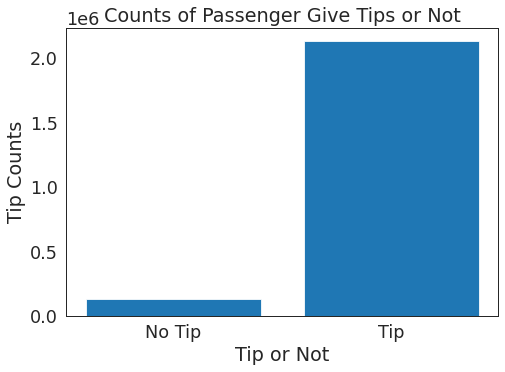

<Figure size 432x288 with 0 Axes>

In [202]:
# plot the Counts to Whether the Passenger Give Tips
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['No Tip', 'Tip']
counts = [(cleaned_data[cleaned_data['tip_amount']==0]).count()['tip_amount'], 
          (cleaned_data[cleaned_data['tip_amount']>0]).count()['tip_amount']]
ax.bar(x,counts)
plt.title("Counts of Passenger Give Tips or Not")
plt.ylabel("Tip Counts")
plt.xlabel("Tip or Not")
plt.show()
plt.savefig('Counts to Whether the Passenger Give Tips.png')

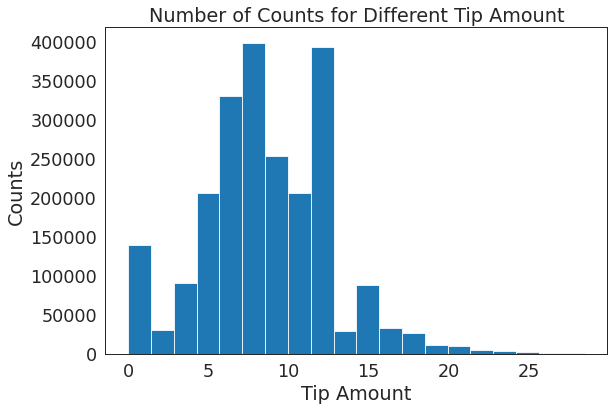

In [184]:
# plot the Number of Counts for Different Tip Amount
plt.figure(figsize=(9, 6))
plt.hist(cleaned_data['tip_amount'], bins = 20)
plt.xlabel("Tip Amount")
plt.ylabel("Counts")
plt.title('Number of Counts for Different Tip Amount')
plt.savefig('Number of Counts for Different Tip Amount.png')
plt.show()

In [203]:
cleaned_data['tip_amount'].mean()

8.511531300412479

### Correlation heatmap

In [172]:
CORR_COLS = ["passenger_count", "trip_distance", "fare_amount", "extra", 
 "mta_tax", "tip_amount", "total_amount", "tolls_amount", "time", "AWND", "PRCP", "SNOW", "SNWD", "TAVG"]
cleaned_data[CORR_COLS].corr()

,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,total_amount,tolls_amount,time,AWND,PRCP,SNOW,SNWD,TAVG
passenger_count,1.000000,0.014604,0.007677,0.004394,0.005277,-0.001189,0.005591,-0.004698,0.009749,0.001351,-0.001460,0.001688,0.002337,-0.001214
trip_distance,0.014604,1.000000,0.808216,0.112992,-0.151185,0.401004,0.765281,0.175593,0.130632,0.006621,0.008841,0.017412,0.005734,-0.000506
fare_amount,0.007677,0.808216,1.000000,0.103890,-0.433413,0.495111,0.968100,0.419583,0.136080,-0.017660,0.009575,0.009215,-0.002893,0.035371
extra,0.004394,0.112992,0.103890,1.000000,0.054560,0.100148,0.162863,-0.045891,0.040400,-0.008558,0.006396,0.007433,0.013035,0.008986
mta_tax,0.005277,-0.151185,-0.433413,0.054560,1.000000,-0.253186,-0.493113,-0.785349,-0.011055,-0.003677,-0.006890,-0.006396,-0.002964,-0.002242
tip_amount,-0.001189,0.401004,0.495111,0.100148,-0.253186,1.000000,0.670579,0.251574,0.050391,0.003088,0.004851,0.004447,0.003491,-0.004484
total_amount,0.005591,0.765281,0.968100,0.162863,-0.493113,0.670579,1.000000,0.510187,0.124525,-0.013347,0.010002,0.009554,-0.000414,0.027836
tolls_amount,-0.004698,0.175593,0.419583,-0.045891,-0.785349,0.251574,0.510187,1.000000,0.017022,0.003609,0.006592,0.005919,0.001913,0.002554
time,0.009749,0.130632,0.136080,0.040400,-0.011055,0.050391,0.124525,0.017022,1.000000,-0.018133,-0.000715,-0.008626,-0.007330,0.027299
AWND,0.001351,0.006621,-0.017660,-0.008558,-0.003677,0.003088,-0.013347,0.003609,-0.018133,1.000000,0.129391,0.120368,0.162547,-0.621287


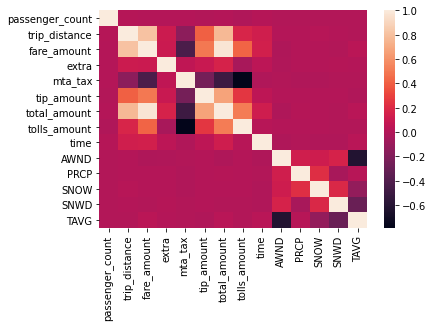

In [175]:
sns.heatmap(cleaned_data[CORR_COLS].corr())
plt.show()

In [177]:
plt.savefig('correlation heatmap.png')

<Figure size 432x288 with 0 Axes>

### Investigate the Type of a day and the tip amount

In [205]:
type_freq/date_num

holiday    11916.750000
weekday    12639.519737
weekend    11333.440000
dtype: float64

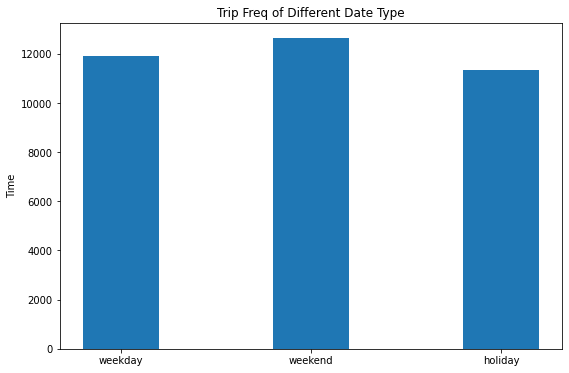

In [143]:
# trip freq of different date type
date_num = cleaned_data.groupby('type')['date'].nunique()
type_freq = cleaned_data['type'].value_counts()
plt.figure(figsize=(9, 6))
plt.bar(type_freq.index, type_freq/date_num, 0.4, label="Trip Freq of Different Date Type")
plt.ylabel("Time")
plt.title('Trip Freq of Different Date Type')
plt.savefig('Trip Freq of Different Date Type.png')
plt.show()

In [140]:
cleaned_data.groupby("type").sum()['tip_amount']/type_freq

holiday    8.260903
weekday    8.539013
weekend    8.367353
dtype: float64

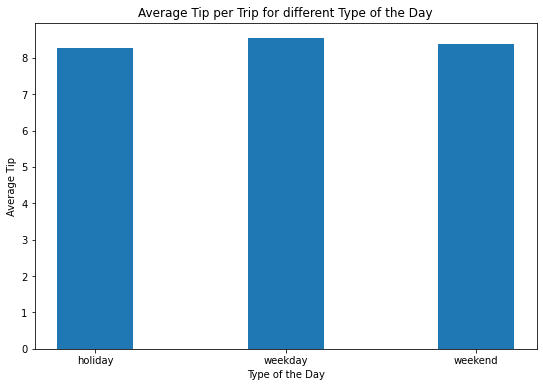

In [144]:
# average tip by type of the day
plt.figure(figsize=(9, 6))
ave_tip = cleaned_data.groupby("type").sum()['tip_amount']/type_freq
plt.bar(ave_tip.index, ave_tip, 0.4)
plt.xlabel("Type of the Day")
plt.ylabel("Average Tip")
plt.title('Average Tip per Trip for different Type of the Day')
plt.savefig('Average Tip per Trip for different Type of the Day.png')
plt.show()

### Investigate the relationship between Time of a day and the tip amount

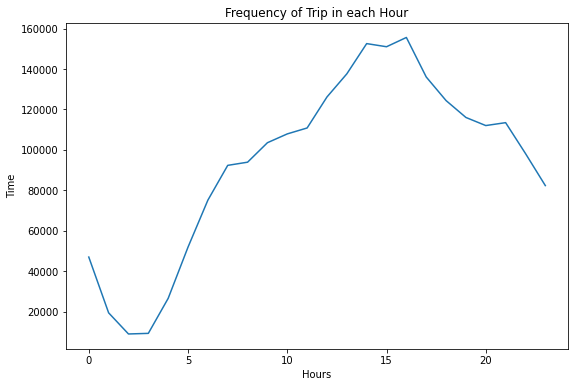

In [107]:
# trip freq by hour
plt.figure(figsize=(9, 6))
count = cleaned_data.groupby("T_hour").count()["tpep_pickup_datetime"]
plt.plot(count.index, count)
plt.ylabel("Time")
plt.xlabel("Hours")
plt.title('Frequency of Trip in each Hour')
plt.savefig('Frequency of Trip in each Hour.png')
plt.show()

In [119]:
cleaned_data.groupby("T_hour").sum()['tip_amount']/cleaned_data.groupby("T_hour").count()["tpep_pickup_datetime"]

T_hour
0     8.008318
1     8.009227
2     7.402047
3     7.813892
4     8.310765
5     8.913031
6     8.878601
7     8.718149
8     8.626777
9     8.540025
10    8.306096
11    8.365440
12    8.487536
13    8.732277
14    8.883858
15    8.866012
16    9.163447
17    8.824053
18    8.492687
19    8.230771
20    8.073531
21    7.975543
22    7.858502
23    7.777722
dtype: float64

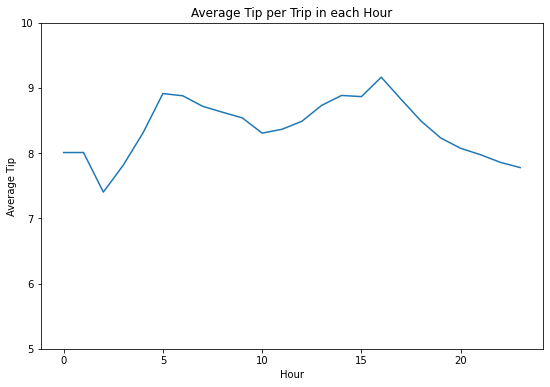

In [123]:
# average tip by hour
plt.figure(figsize=(9, 6))
ave_tip = cleaned_data.groupby("T_hour").sum()['tip_amount']/cleaned_data.groupby("T_hour").count()["tpep_pickup_datetime"]
plt.plot(ave_tip.index, ave_tip)
plt.xlabel("Hour")
plt.ylabel("Average Tip")
plt.ylim(5, 10)
plt.title('Average Tip per Trip in each Hour')
plt.savefig('Average Tip per Trip in each Hour.png')
plt.show()

### Investigate differece in the number of pickups in weekdays and in weekends

In [6]:
date_count = cleaned['date'].value_counts().sort_index()
date_count

01-01     9825
01-02    10525
01-03     9656
01-04     2231
01-05     7764
         ...  
06-26    13131
06-27    13868
06-28    12866
06-29    13812
06-30     7654
Name: date, Length: 181, dtype: int64

In [24]:
# get the date of weekends
from datetime import date as dt
from datetime import timedelta

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
start_dt = date(2018,1,1)
end_dt = date(2018,6,30)

weekends = []
weekdays = [6,7]
for dt in daterange(start_dt, end_dt):
    if dt.isoweekday() in weekdays:
        weekends.append(dt.strftime("%m-%d"))

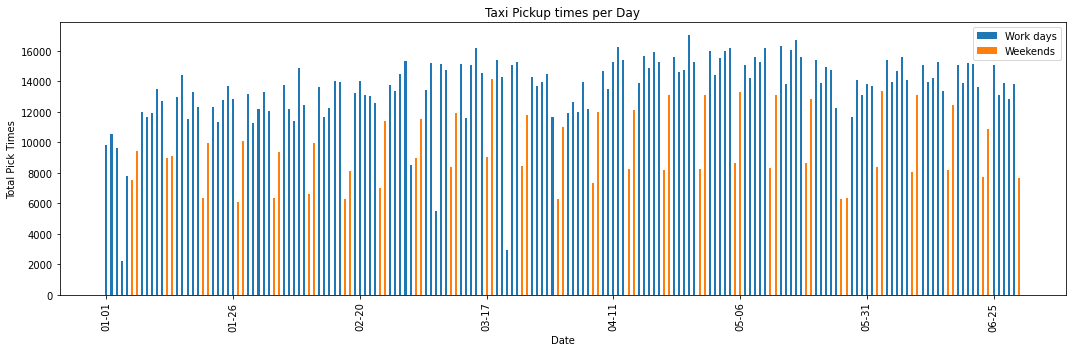

In [38]:
from matplotlib.dates import DateFormatter

# classify the day into weekday or weekend
weekend_bar_count = date_count
for i in range(len(weekend_bar_count)):
    if weekend_bar_count.index[i] not in weekends:
        weekend_bar_count[weekend_bar_count.index[i]] = 0
        
# plot the graph of Taxi Pickup times per Day, comparing the pick-up in weekday and weekend
labels = date_count.index
date_count = cleaned['date'].value_counts().sort_index()

x = np.arange(len(labels))
width = 0.4

fig, ax = plt.subplots(figsize=(15,5))
work_bar = ax.bar(x, date_count, width, label='Work days')
weekend_bar = ax.bar(x, weekend_bar_count, width, label='Weekends')
ax.set_ylabel('Total Pick Times')
ax.set_title('Taxi Pickup times per Day')
ax.set_xlabel('Date')
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.legend()
plt.xticks(rotation=90)

fig.tight_layout()
plt.show()

### Investigate the top drop off locations

In [39]:
df.groupby('PULocationID')['payment_type'].count().reset_index().sort_values('payment_type', ascending=False)

,PULocationID,payment_type
131,138.0,823418
125,132.0,419745
222,230.0,74665
154,161.0,61481
155,162.0,57248
...,...,...
180,187.0,3
4,5.0,2
104,111.0,1
81,84.0,1


In [40]:
import geopandas as gpd

# sf stands for shape file
sf = gpd.read_file("../raw_data/taxi_zones.shp")
zone = pd.read_csv("../raw_data/taxi+_zone_lookup.csv")

# Convert the geometry shaape to to latitude and longitude
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")

In [41]:
DO_count = cleaned['DOLocationID'].value_counts().sort_index()
DO_count = pd.DataFrame({"LocationID":DO_count.index, "DO_Count":DO_count})
gdf = gpd.GeoDataFrame(pd.merge(DO_count, sf, left_on='LocationID', right_on='LocationID')).drop('LocationID', axis=1)
gdf.sort_values("DO_Count",ascending=False)

,DO_Count,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
133,380098,138,0.107467,0.000537,LaGuardia Airport,Queens,"MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ..."
127,208937,132,0.245479,0.002038,JFK Airport,Queens,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ..."
225,101465,230,0.031028,0.000056,Times Sq/Theatre District,Manhattan,"POLYGON ((-73.98362 40.75552, -73.98412 40.754..."
157,76949,162,0.035270,0.000048,Midtown East,Manhattan,"POLYGON ((-73.97122 40.75519, -73.97168 40.754..."
156,74045,161,0.035804,0.000072,Midtown Center,Manhattan,"POLYGON ((-73.97534 40.75530, -73.97581 40.754..."
...,...,...,...,...,...,...,...
29,20,30,0.094510,0.000146,Broad Channel,Queens,"POLYGON ((-73.82076 40.61523, -73.81769 40.614..."
58,15,59,0.037795,0.000063,Crotona Park,Bronx,"POLYGON ((-73.88942 40.83942, -73.88869 40.839..."
98,10,99,0.183371,0.001210,Freshkills Park,Staten Island,"POLYGON ((-74.16843 40.58650, -74.16895 40.583..."
1,8,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."


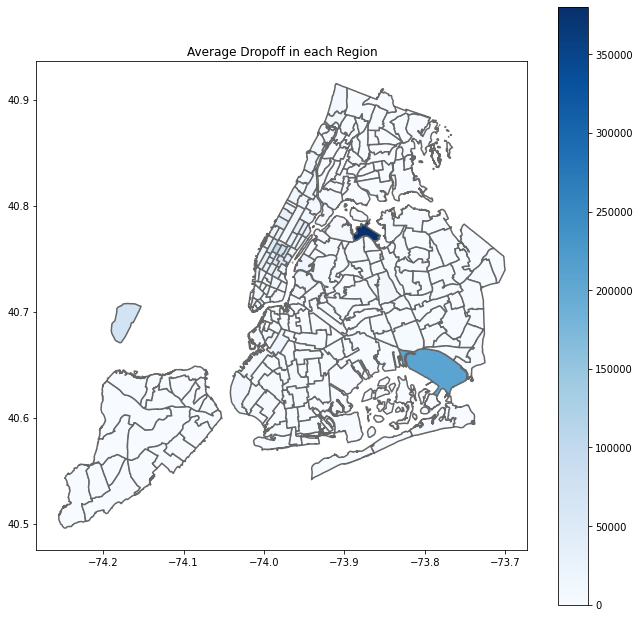

In [42]:
# plot the map showing drop off locations
variable = 'DO_Count'

vmin, vmax = 0, gdf['DO_Count'].max()

fig, ax = plt.subplots(1, figsize=(11,11))

ax.set_title('Average Dropoff in each Region')

sn = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

sn.set_array([])

fig.colorbar(sn)

gdf.plot(column=variable, cmap='Blues', linewidth=1.5, ax=ax, edgecolor='0.4')
plt.savefig('Average Dropoff in each Region.png')
plt.show()

### Investigate the top tipped region

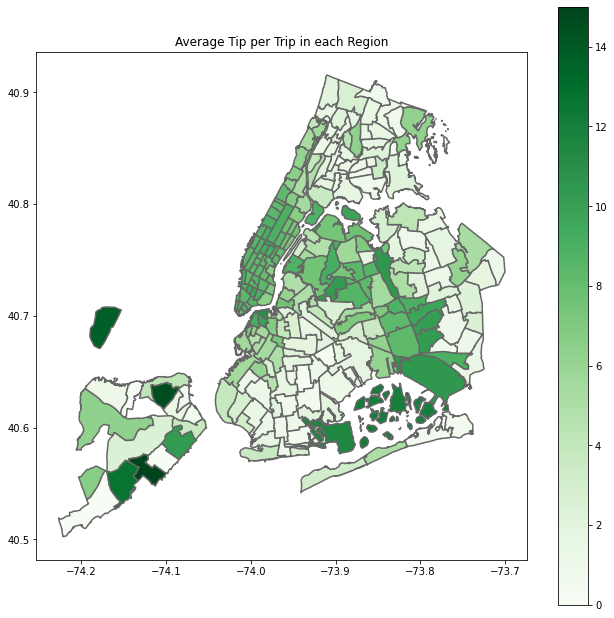

In [47]:
# plot the map showing ave tip in each region
variable = 'tip_region'

vmin, vmax = 0, gdf['tip_region'].max()

fig, ax = plt.subplots(1, figsize=(11,11))

ax.set_title('Average Tip per Trip in each Region')

sn = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=vmin, vmax=vmax))

sn.set_array([])

fig.colorbar(sn)

gdf.plot(column=variable, cmap='Greens', linewidth=1.5, ax=ax, edgecolor='0.4')
plt.savefig('Average Tip per Trip in each Region.png')
plt.show()

In [48]:
tip_region = cleaned.groupby('PULocationID')['tip_amount'].sum()/cleaned['PULocationID'].value_counts().sort_index()
tip_region = pd.DataFrame({"LocationID":tip_region.index, "tip_region":tip_region})
gdf = gpd.GeoDataFrame(pd.merge(tip_region, sf, left_on='LocationID', right_on='LocationID')).drop('LocationID', axis=1)
top_10 = gdf.sort_values("tip_region",ascending=False)[:10]
top_10

,tip_region,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
168,15.000000,176,0.151995,0.000658,Oakwood,Staten Island,"POLYGON ((-74.12187 40.57511, -74.12187 40.575..."
236,14.566667,245,0.095983,0.000466,West Brighton,Staten Island,"POLYGON ((-74.09788 40.64036, -74.09767 40.638..."
0,13.736239,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
102,12.686667,109,0.178268,0.001170,Great Kills,Staten Island,"POLYGON ((-74.14706 40.57051, -74.14699 40.570..."
1,12.067500,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
146,11.480937,154,0.227332,0.001790,Marine Park/Floyd Bennett Field,Brooklyn,"MULTIPOLYGON (((-73.93531 40.60886, -73.93423 ..."
63,11.003750,66,0.054633,0.000108,DUMBO/Vinegar Hill,Brooklyn,"POLYGON ((-73.97906 40.70595, -73.97925 40.705..."
90,10.537555,93,0.170998,0.000594,Flushing Meadows-Corona Park,Queens,"POLYGON ((-73.85696 40.76407, -73.85667 40.763..."
124,10.499913,132,0.245479,0.002038,JFK Airport,Queens,"MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ..."
205,10.275333,214,0.135300,0.000812,South Beach/Dongan Hills,Staten Island,"POLYGON ((-74.08491 40.59570, -74.08407 40.595..."


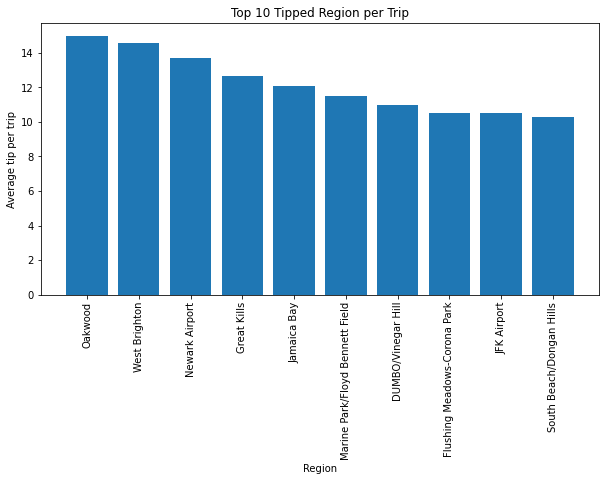

In [49]:
# plot the top 10 tipped regions
fig, ax = plt.subplots(figsize=(10,5))

ax.bar(top_10['zone'], top_10['tip_region'])

ax.set_title('Top 10 Tipped Region per Trip')
ax.set_ylabel('Average tip per trip')
ax.set_xlabel('egion')

ax.set_xticklabels(top_10['zone'].values)
ax.set_xticks(top_10['zone'].values)
plt.xticks(rotation=90)

fig.tight_layout
plt.show()
plt.close()

fig.savefig('Top 10 Tipped Region per Trip.png')

### Sampling

In [214]:
# sample 0.01 of the data
sample = cleaned_data.sample(frac=0.01, replace=True, random_state=1)
sample = sample.sort_values(by=['tpep_pickup_datetime']).reset_index(drop=True)
sample

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,DATE,AWND,PRCP,SNOW,SNWD,TAVG,bad weather,time,T_hour,type
0,2,2018-01-01 01:30:44,2018-01-01 01:53:15,2,17.13,2,N,132,137,1,...,01-01,7.83,0.0,0.0,0.0,-10.555556,N,22.516667,1,holiday
1,2,2018-01-01 01:41:09,2018-01-01 02:27:03,1,30.94,5,N,164,265,1,...,01-01,7.83,0.0,0.0,0.0,-10.555556,N,45.900000,1,holiday
2,1,2018-01-01 04:29:38,2018-01-01 04:55:48,3,9.10,1,N,230,17,1,...,01-01,7.83,0.0,0.0,0.0,-10.555556,N,26.166667,4,holiday
3,2,2018-01-01 04:54:15,2018-01-01 05:18:48,1,16.41,2,N,162,132,1,...,01-01,7.83,0.0,0.0,0.0,-10.555556,N,24.550000,4,holiday
4,1,2018-01-01 05:43:37,2018-01-01 06:11:02,2,17.70,2,N,163,132,1,...,01-01,7.83,0.0,0.0,0.0,-10.555556,N,27.416667,5,holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22517,2,2018-06-30 23:00:22,2018-06-30 23:39:20,1,18.58,2,N,132,262,1,...,06-30,2.24,0.0,0.0,0.0,28.055556,N,38.966667,23,weekday
22518,2,2018-06-30 23:03:18,2018-06-30 23:50:55,1,17.78,2,N,132,100,1,...,06-30,2.24,0.0,0.0,0.0,28.055556,N,47.616667,23,weekday
22519,1,2018-06-30 23:08:17,2018-06-30 23:49:47,1,21.50,2,N,132,233,1,...,06-30,2.24,0.0,0.0,0.0,28.055556,N,41.500000,23,weekday
22520,2,2018-06-30 23:21:35,2018-06-30 23:41:42,1,6.93,1,N,138,41,1,...,06-30,2.24,0.0,0.0,0.0,28.055556,N,20.116667,23,weekday


In [215]:
sample.reset_index().to_csv('sample.csv')